In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch as tt
import scipy.spatial
import csv
import json
import os
import nltk

from typing import List, Tuple, Union

from transformers import BertTokenizer, BertModel
from ast import literal_eval
from tqdm import tqdm_notebook

os.chdir("..")

from gensim.models import KeyedVectors
from collections import defaultdict
from distractor_generator.resources import get_word2vec_model

Признаки:

 - BERT-вектор специального токена [MASK] на месте области ошибки
 - Усреднённый BERT-вектор исправленного предложения
 - Word2Vec-вектор слова в исправлении
 - Word2Vec-вектор ошибочного варианта
 - Частотность исправления в корпусе
 - Частотность искажённого варианта для данного исправления в корпусе
 - Частотность слова в исправлении в корпусе в целом (не только в исправлениях ошибок)
 - Частотность ошибочного варианта в корпусе в целом

In [2]:
class BertEmbedder:
    def __init__(self, model_name: str):
        self.model = BertModel.from_pretrained(model_name)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

    def _process_data(self, data: Union[str, List[str]]) -> tt.Tensor:
        tokenized = self.tokenizer(data, return_tensors="pt")
        with tt.no_grad():
            output = self.model(**tokenized)
        h = output.last_hidden_state
        return h, tokenized

    def embed_sentence(self, sent: str) -> List[float]:
        h, _ = self._process_data(sent)
        h_mean = h[0].mean(axis=0).numpy().tolist()
        return h_mean

    def embed_mask_token(self, sent: str) -> List[float]:
        h, tokenized = self._process_data(sent)
        h, tokenized = h[0], tokenized["input_ids"][0]
        mask_index = tokenized.numpy().tolist().index(self.tokenizer.mask_token_id)
        mask_embedding = h[mask_index].numpy().tolist()
        return mask_embedding

    def embed_tokens(self, sent: str) -> List[Tuple[str, float]]:
        h, tokenized = self._process_data(sent)
        h, tokenized = h[0], tokenized["input_ids"][0]
        tokens = self.tokenizer.convert_ids_to_tokens(tokenized)

        output = []

        for token, vector in zip(tokens, h):
            output.append((token, vector.numpy().tolist()))

        return output

In [3]:
df = []

df = pd.read_csv(
    "data/dataset_lexics_final3.csv",
    sep=';',
    index_col="Unnamed: 0"
)

df = df.loc[df["Delete"]!=1.0]

df = df.drop(["Delete","Revisited1"], axis=1)

df = df.dropna(subset=["target_true"])
df["target_true"] = df["target_true"].astype(np.double).astype(np.int64)
df["target"] = df["target"].astype(np.double).astype(np.int64)

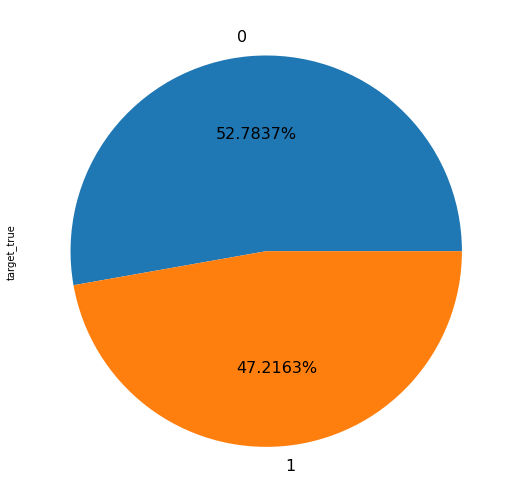

In [4]:
def my_fmt(x):
    return '{:.4f}%'.format(x)

fig, ax = plt.subplots(figsize=[12,9])
df["target_true"].value_counts().plot.pie(ax=ax, fontsize=16, autopct=my_fmt)
plt.savefig("latest_target_true.png", bbox_inches="tight")

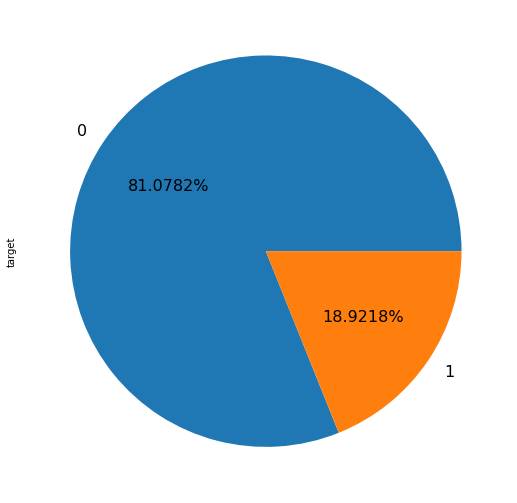

In [5]:
fig, ax = plt.subplots(figsize=[12,9])
df["target"].value_counts().plot.pie(ax=ax, fontsize=16, autopct=my_fmt)
plt.savefig("latest_target.png", bbox_inches="tight")

In [6]:
df["target_true"].value_counts()

0    1498
1    1340
Name: target_true, dtype: int64

In [7]:
count_pos = 0
count_neg = 0

for sent_id in df["sent_id"].unique():
    df_sent = df.loc[df["sent_id"] == sent_id]
    count_pos += df_sent["target_true"].value_counts().get(1, default=0)
    count_neg += df_sent["target_true"].value_counts().get(0, default=0)

count_pos /= len(df["sent_id"].unique())
count_neg /= len(df["sent_id"].unique())

print(count_pos, count_neg)

1.7135549872122762 1.9156010230179028


In [8]:
df.head()

,sent_id,target,variant,correction,masked_sent,variant_count,correction_count,error_type,target_true,File,Folder,Filename
Unnamed: 0,,,,,,,,,,,,
1167,88.0,1,understandings,perceptions,"To start with, happiness is a feeling of comf...",1,1,lex_item_choice,1,2014_EZa_13_2,exam/Exam2014,exam/Exam2014/2014_EZa_13_2
1173,93.0,1,strictly,absolutely,I know that she was healthy and that her birt...,2,5,lex_item_choice,1,2014_EZa_13_2,exam/Exam2014,exam/Exam2014/2014_EZa_13_2
1174,93.0,0,completely,absolutely,I know that she was healthy and that her birt...,2,5,lex_item_choice,0,2014_EZa_13_2,exam/Exam2014,exam/Exam2014/2014_EZa_13_2
1187,93.0,0,definitely,absolutely,I know that she was healthy and that her birt...,1,5,lex_item_choice,1,2014_EZa_13_2,exam/Exam2014,exam/Exam2014/2014_EZa_13_2
2332,171.0,0,number,level,The chart below represents the information abo...,13,39,lex_item_choice,1,2017_OBy_85_1,exam/Exam2017/OBy_1-99,exam/Exam2017/OBy_1-99/2017_OBy_85_1


In [9]:
len(df)

2838

In [10]:
df["target_true"].value_counts()

0    1498
1    1340
Name: target_true, dtype: int64

Оставим только варианты, в которых возможно совпадение дистрактора и правильного ответа по POS-тэгу:

In [11]:
brown_corpus_tags = pd.read_csv(
    "data/brown_corpus_tags.csv",
    sep=';',
    index_col="Unnamed: 0"
).rename(columns={'0':"tags"})
brown_corpus_tags["tags"] = brown_corpus_tags["tags"].apply(literal_eval)

brown_corpus_tags = brown_corpus_tags.to_dict()["tags"]

d = defaultdict(list)
for item in brown_corpus_tags:
    d[item] = brown_corpus_tags[item]

brown_corpus_tags = d

In [12]:
df = df.loc[
    df.apply(
        lambda x: len(
            set(
                brown_corpus_tags[x["variant"]]
            ) & set(
                brown_corpus_tags[x["correction"]]
            )
        ) >= 1,
        axis=1
    )
]

In [13]:
len(df)

2838

Отсеем варианты, где и исправление, и область ошибки в контексте предложения выступают в роли предлога или местоимения:

In [14]:
functional_tags = [
    "CC", "DT", "IN", "POS", "TO", "WDT", "WP", "WP$", "WRB"
]

def is_functional(
    masked_sent: str,
    variant: str
):
    index = nltk.word_tokenize(masked_sent).index('[')
    tagged = nltk.pos_tag(
        nltk.word_tokenize(
            masked_sent.replace("[MASK]", variant)
        )
    )
    tag = tagged[index][1]
    return tag in functional_tags

df = df.loc[
    ~df.apply(
        lambda x: is_functional(x["masked_sent"], x["correction"]) and is_functional(x["masked_sent"], x["variant"]),
        axis=1
    )
]

In [15]:
len(df)

2838

In [16]:
word2vec = get_word2vec_model()

In [17]:
bert = BertEmbedder("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
import json

In [19]:
with open("data/freqdict.json",'r',encoding='utf-8') as inp:
    freqdict = json.load(inp)

In [20]:
df = df.dropna(
    subset = ["sent_id"],
    axis = 0
)

In [21]:
bert_masked_embeds = dict()
bert_sent_embeds = dict()

sent_ids = df["sent_id"].unique()

for index in tqdm_notebook(sent_ids, total=len(sent_ids)):
    row = df.loc[df["sent_id"]==index].iloc[0]
    bert_masked_embeds[index] = bert.embed_mask_token(
        row["masked_sent"]
    )
    bert_sent_embeds[index] = bert.embed_sentence(
        row["masked_sent"].replace('[MASK]', row['correction'])
    )

C:\Users\User\AppData\Local\Temp\ipykernel_12748\1946419533.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(sent_ids, total=len(sent_ids)):


  0%|          | 0/782 [00:00<?, ?it/s]

In [22]:
len(df)

2838

In [23]:
def process_entry(entry: dict) -> dict:
    output_dict = dict()
    
    output_dict["index"] = entry["Unnamed: 0"]
    output_dict["sent_id"] = entry["sent_id"]
    output_dict["target"] = entry["target"]
    output_dict["target_true"] = entry["target_true"]
    
    # bm_i
    bert_masked = bert_masked_embeds[entry["sent_id"]]
    for i in range(len(bert_masked)):
        output_dict[f"bm_{i}"] = bert_masked[i]
    
    #bs_i
    bert_sent = bert_sent_embeds[entry["sent_id"]]
    for i in range(len(bert_sent)):
        output_dict[f"bs_{i}"] = bert_sent[i]
    
    #wve_i
    if entry["variant"] in word2vec:
        wve = word2vec[entry["variant"]]
        for i in range(len(wve)):
            output_dict[f"wve_{i}"] = wve[i]
    else:
        return None
    
    #wvc_i
    if entry["correction"] in word2vec:
        wvc = word2vec[entry["correction"]]
        for i in range(len(wvc)):
            output_dict[f"wvc_{i}"] = wvc[i]
    else:
        return None
    
    #freq_corr
    output_dict["freq_corr"] = entry["correction_count"]
    
    #freq_err_corr
    output_dict["freq_err_corr"] = entry["variant_count"]
    
    #freq_corr_corp
    if entry["correction"] in freqdict:
        output_dict["freq_corr_corp"] = freqdict[entry["correction"]]
    else:
        return None
    
    #freq_err_corp
    if entry["variant"] in freqdict:
        output_dict["freq_err_corp"] = freqdict[entry["variant"]]
    else:
        return None
    
    return output_dict

In [24]:
df = df.reset_index().to_dict(orient="records")


In [25]:
output_df = []

for entry in tqdm_notebook(df, total=len(df)):
    output_dict = process_entry(entry)
    if output_dict:
        output_df.append(output_dict)

C:\Users\User\AppData\Local\Temp\ipykernel_12748\1326514453.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for entry in tqdm_notebook(df, total=len(df)):


  0%|          | 0/2838 [00:00<?, ?it/s]

In [26]:
%%time
output_df = pd.DataFrame(output_df).set_index("index")

CPU times: total: 1.62 s
Wall time: 1.74 s


In [27]:
output_df["target"].value_counts()

0    2301
1     536
Name: target, dtype: int64

In [28]:
output_df["target_true"].value_counts()

0    1498
1    1339
Name: target_true, dtype: int64

In [29]:
output_df

,sent_id,target,target_true,bm_0,bm_1,bm_2,bm_3,bm_4,bm_5,bm_6,...,wvc_294,wvc_295,wvc_296,wvc_297,wvc_298,wvc_299,freq_corr,freq_err_corr,freq_corr_corp,freq_err_corp
index,,,,,,,,,,,,,,,,,,,,,
1167,88.0,1,1,0.289653,0.659942,0.857995,0.456219,0.229857,0.317379,0.435600,...,-0.249210,-0.021673,-0.116785,-0.108414,0.161148,0.354648,1,1,1,5
1173,93.0,1,1,-0.112628,-0.088576,-0.228539,-0.125512,-0.287560,0.014738,-0.212544,...,0.207804,-0.022905,-0.255043,-0.053252,-0.093926,-0.076468,5,2,707,89
1174,93.0,0,0,-0.112628,-0.088576,-0.228539,-0.125512,-0.287560,0.014738,-0.212544,...,0.207804,-0.022905,-0.255043,-0.053252,-0.093926,-0.076468,5,2,707,864
1187,93.0,0,1,-0.112628,-0.088576,-0.228539,-0.125512,-0.287560,0.014738,-0.212544,...,0.207804,-0.022905,-0.255043,-0.053252,-0.093926,-0.076468,5,1,707,350
2332,171.0,0,1,-0.057980,0.168899,-0.199607,0.063531,-0.194752,-0.328900,0.319228,...,-0.033753,-0.761193,-0.044005,-0.092704,-0.432252,0.390534,39,13,4024,10015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695022,37399.0,0,1,0.182501,-0.010592,-0.631144,-0.054599,-0.031649,0.448475,0.056622,...,-0.082141,0.010859,-0.191100,-0.111232,-0.197992,0.006448,10,2,1989,906
695024,37399.0,0,0,0.182501,-0.010592,-0.631144,-0.054599,-0.031649,0.448475,0.056622,...,-0.082141,0.010859,-0.191100,-0.111232,-0.197992,0.006448,10,2,1989,325
695025,37399.0,0,0,0.182501,-0.010592,-0.631144,-0.054599,-0.031649,0.448475,0.056622,...,-0.082141,0.010859,-0.191100,-0.111232,-0.197992,0.006448,10,1,1989,2759


In [30]:
len(output_df["sent_id"].unique())

781

In [31]:
output_df.to_csv("data/processed_dataset_final.csv", sep=';')

In [32]:
sent_ids_in = [int(i) for i in pd.DataFrame(df)["sent_id"]]

In [33]:
sent_ids_out = [int(i) for i in output_df["sent_id"]]

In [34]:
sent_id0 = [i for i in sent_ids_in if i not in sent_ids_out]

In [35]:
sent_id0

[19980]

In [36]:
df = pd.DataFrame(df)

In [37]:
df.loc[df["sent_id"]==19980]

,Unnamed: 0,sent_id,target,variant,correction,masked_sent,variant_count,correction_count,error_type,target_true,File,Folder,Filename
1426,369455,19980.0,1,left,dumped,"So, the conclusion is that using cars can giv...",1,1,lex_item_choice,1,2016_MTsy_47_2,exam/Exam2016,exam/Exam2016/2016_MTsy_47_2


In [38]:
"left" in freqdict

True

In [39]:
"dumped" in freqdict

False